In [9]:
import os
import datetime
from datetime import datetime as dt
from datagenic_rest_client.datagenic import DataGenic
# from DG import get_prices_df
import pandas as pd
import statsmodels.api as sm
import requests, warnings
import matplotlib.pyplot as plt
from tshistory.api import timeseries

tsa = timeseries('http://tst-qdev-ap9.petroineos.local/api')
plt.style.use('ggplot')

Aim: regressing trades diffs against lsfo crack, structure and freight
<br>improvements: 
* Add outages for doba refineries, 
* doba S&D view to itegrate into this as another regressor? 
* splitter margins
* create netback margins via python

Work in progress
* convert all prods to $/bbl
* calculate netback margins in table

In [2]:
datagenic_rest_server = "http://lon-qdev-ap11"
new_url = 'https://petroineos-prod-gdm-ew1.prod.tr.enverus.com:443'

# dg = DataGenic(
#     url_rest_wrapper=datagenic_rest_server, datagenic_url=os.environ["datagenicserver"],
#   datagenic_username=os.environ["datagenicusername"], datagenic_password=os.environ["datagenicpassword"])

dg = DataGenic(
    url_rest_wrapper=datagenic_rest_server, datagenic_url=new_url,
  datagenic_username=os.environ["datagenicusername"], datagenic_password=os.environ["datagenicpassword"])

In [ ]:
def safe_register_formula(tsa, name, formula):
    if tsa.exists(name):
        tsa.delete(name)
    tsa.register_formula(name, formula)

In [5]:
def ag_get_data(query):
    warnings.simplefilter('ignore', requests.packages.urllib3.exceptions.InsecureRequestWarning)
    params = {"Database": "OIL", "Query": query}
    resp = requests.post('https://TST-QDEV-AP1.petroineos.local:5001/genericdata/Fetch/', json=params, verify=False)
    json_result = resp.json()
    df = pd.DataFrame(json_result)
    return df

In [10]:
def get_traded_diffs_cleaned():
    doba_diff_url = r'C:\Users\syedahmad\Documents\doba\doba_traded_diffs.csv'
    traded_diffs = pd.read_csv(doba_diff_url)
    traded_diffs['trade_date'] = pd.to_datetime(traded_diffs['trade_date'])
    diffs_unique = traded_diffs.groupby('trade_date').mean()
    diffs_unique.fillna(method='ffill', inplace=True)
    diffs_daily = diffs_unique.resample('D').interpolate()
    return diffs_daily

### platts doba vs traded diffs

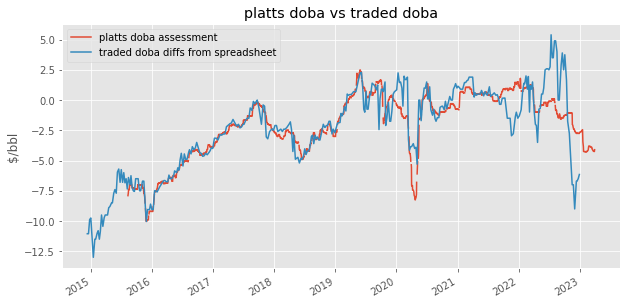

In [11]:
platts_doba = dg.get_time_series(model_url='model://PLATTS_RI/PLATTS.CRUDE.RI.AAXUV00', from_date=dt(2015,1,1), to_date=dt.today())
doba_prices = pd.concat([platts_doba,get_traded_diffs_cleaned()], axis=1)
doba_prices.columns = ['platts doba assessment','traded doba diffs from spreadsheet']
doba_prices.plot(figsize=(10,5), title='platts doba vs traded doba', ylabel='$/bbl')

In [15]:
name = 'price.platts.doba.diff_to_dated.usd_bbl.daily'
# tsa.update(platts_doba, 'Syed Ahmad')
tsa.update(name=name, series=platts_doba, author='Syed Ahmad')

TypeError: Object of type StringMethods is not JSON serializable

### -------------- upload regression formula to saturn --------------

In [43]:
def regression():
    diffs = get_traded_diffs_cleaned()
    spread = tsa.get('price.platts.ice_brent_swap_spread.m01.usd_bbl.daily')
    freight = tsa.get('freight.platts.waf.ukc.dirty.suezmax_130kt.usd_t.daily')
    production = tsa.get('crude.rystad.doba_blend.production.kbd.monthly').resample('D').ffill()
    outage = tsa.get('oil.petroineos.oecd_europe.cdu.total_outage_plus_economic.kbd.daily')
    asian_short = tsa.get('crude.petroineos.asia.net_length.kbd.monthly').resample('D').ffill()
    df = pd.concat([diffs,spread, freight, production, outage, asian_short], axis=1)
    df.columns = ['traded_diff','spread','freight','production', 'eu_outages', 'asian_short']    
    corr = df.resample('D').interpolate()
    corr_19 = corr.loc['2020':'2022'] 
    x = corr_19[['spread', 'freight','production','eu_outages','asian_short']]
    y = corr_19['traded_diff']
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    return model.params

In [44]:
params = regression()

C:\Users\SYEDAH~1\AppData\Local\Temp/ipykernel_960/1475051520.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  diffs_unique = traded_diffs.groupby('trade_date').mean()


In [ ]:
formula = f'''
(+
    {params.const}
    (add
        (*
            {params.spread}
            (series "price.platts.ice_brent_swap_spread.m01.usd_bbl.daily"))
        (*
            {params.freight}
            (series "freight.platts.waf.ukc.dirty.suezmax_130kt.usd_t.daily"))
        (*
            {params.production}           	
        (mul
            (series "one.daily.naive")
            (series "crude.rystad.doba_blend.production.kbd.monthly" #:fill "ffill" )))
        (*
            {params.eu_outages}
            (series "oil.petroineos.oecd_europe.cdu.total_outage_plus_economic.kbd.daily"))
        (*
            {params.asian_short}
            (mul
                (series "one.daily.naive")
                (series "crude.petroineos.asia.net_length.kbd.monthly" #:fill "ffill")))
    ))
'''

In [ ]:
safe_register_formula(tsa,'price.petroineos.doba_fair_value.usd_b.daily', formula)

### -------------- broad regression of variables to traded diffs --------------

key point: crack and the structure has the largest influence on regression and predictive power for Doba traded diff

In [16]:
ks = ('2017551', '2017557')
fujairah = ('2182914', '2090180')
# rotts = ('2090179')
tianjin = ('2061771','2046757')
rayong = ('2020317', '2028566', '2029894')

In [8]:
def get_outages():
    ks = ('2017551', '2017557')
    doba_consumers_unit_ids = ('2017551', '2017557', '2182914', '2090180', '2061771','2046757', '2020317', '2028566', '2029894')
    qry = f'''select OUTAGE_DATE, sum(CAP_OFFLINE) outage from oil.refinery.MaintenanceDaily
        where UNIT_ID in {doba_consumers_unit_ids} 
        and pdate = (select max(pdate) from oil.refinery.MaintenanceDaily)
        group by OUTAGE_DATE
        order by OUTAGE_DATE asc'''
    return ag_get_data(qry).set_index('OUTAGE_DATE')

In [12]:
def get_regressors():
    from_date = datetime.date(2015, 1, 1)

    models = {
        'lsfo' : 'model://PI_OIL_PROD_HEA/PI.FO10.CCIFNWE.USD.MT.C/CURVE/M01/FINAL',
        # 'vlsfo':"model://PI_OIL_PROD_HEA/PI.MARINEFO.CFOBSING.USD.MT.C/CURVE/M01/FINAL",
        'dtd':"model://PLATTS_RI/PLATTS.CRUDE.RI.PCAAS00",
        'm1' : 'model://PI_OIL_CRU_ICE/PI.BRENT.ICESWAP.USD.BBL.C/CURVE/M01/FINAL',
        'm2' : 'model://PI_OIL_CRU_ICE/PI.BRENT.ICESWAP.USD.BBL.C/CURVE/M02/FINAL',
        'freight' : 'model://PLATTS_TD/PLATTS.FR.TD.TDACR00',
        'doba':"model://PLATTS_RI/PLATTS.CRUDE.RI.AAXUV00",
    }
    production = tsa.get('crude.rystad.doba_blend.production.kbd.monthly').resample('D').ffill()
    outage = tsa.get('oil.petroineos.oecd_europe.cdu.total_outage_plus_economic.kbd.daily')
    asian_short = tsa.get('crude.petroineos.asia.net_length.kbd.monthly').resample('D').ffill()
    ts_data = pd.concat([production, outage, asian_short], axis=1)
    ts_data.columns = ['production', 'eu_outages', 'asian_short']
    df = get_prices_df(models, from_date)
    df['spread'] = df['m1'] - df['m2']
    df['lsfo_bbl'] = df['lsfo']/6.33
    df['crack'] = df['lsfo_bbl'] - df['m1']
    df = df.merge(ts_data, left_index=True, right_index=True)
    return df

In [15]:
outages = get_outages()
regressors = get_regressors().merge(outages, how='left', left_index=True, right_index=True)
regressors['asian_outages'] = regressors['outage'].fillna(0)

# regressors = get_regressors()
diffs = get_traded_diffs_cleaned()
corr = diffs.merge(regressors, how='left', left_index=True, right_index=True).fillna(method='ffill')

C:\Users\SYEDAH~1\AppData\Local\Temp/ipykernel_960/1475051520.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  diffs_unique = traded_diffs.groupby('trade_date').mean()


In [17]:
# modeling OLS 
corr_19 = corr.loc['2020':].copy()
# x = corr_19[['crack', 'spread', 'freight','m1','production','eu_outages','asian_outages']]
x = corr_19[['spread', 'freight','production','eu_outages','asian_short']]
y = corr_19['Tracking (based on load date)']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
model.summary()

TypeError: '<' not supported between instances of 'Timestamp' and 'str'

In [35]:
params.const

-13.388301109058048

In [41]:
corr_19['fcast'] = corr_19.apply(lambda x: params.const + params.spread*x['spread'] + params.freight*x['freight'] + params.production*x['production'] + params.eu_outages*x['eu_outages'] + params.asian_short*x['asian_short'], axis=1)

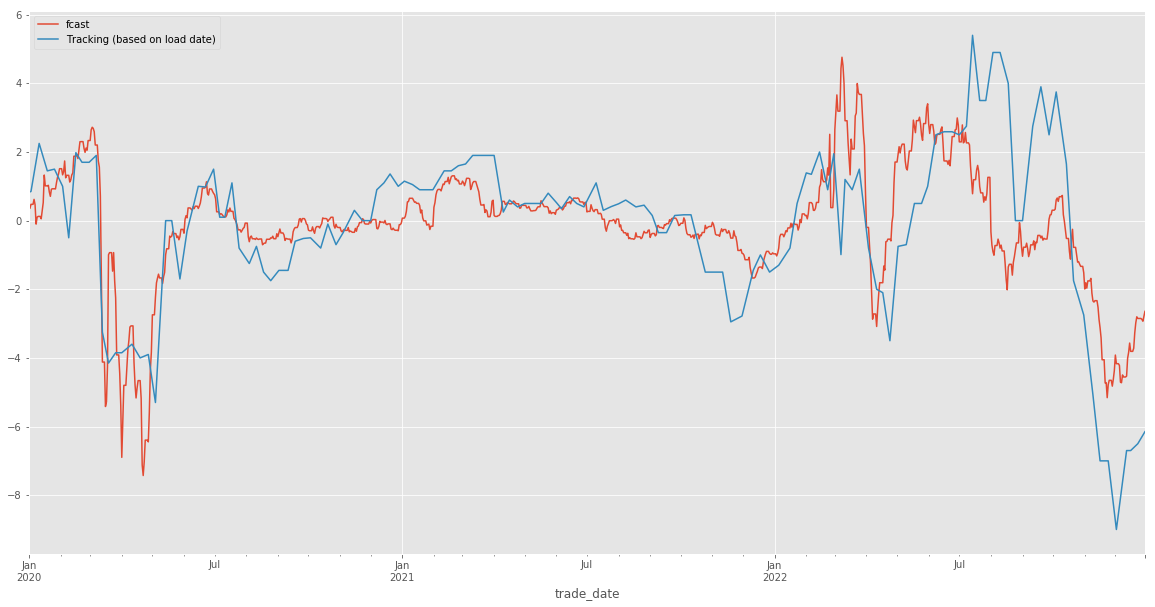

In [44]:
corr_19.plot(y=['fcast', 'Tracking (based on load date)'], figsize=(20,10))

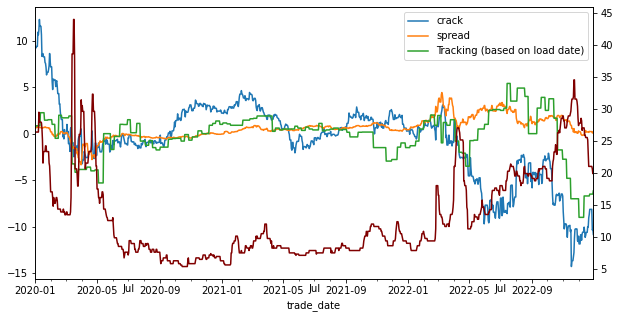

In [10]:
ax = corr_19.plot(y=['crack', 'spread', 'Tracking (based on load date)'], figsize=(10,5))
ax2 = ax.twinx()
ax2 = ax2.plot(corr_19.freight, color='maroon')

In [107]:
# modeling OLS 
x = corr_19[['crack', 'spread', 'doba']]
y = corr_19['Tracking (based on load date)']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     Tracking (based on load date)   R-squared:                       0.412
Model:                                       OLS   Adj. R-squared:                  0.410
Method:                            Least Squares   F-statistic:                     254.6
Date:                           Fri, 10 Mar 2023   Prob (F-statistic):          3.25e-125
Time:                                   14:43:47   Log-Likelihood:                -2210.5
No. Observations:                           1095   AIC:                             4429.
Df Residuals:                               1091   BIC:                             4449.
Df Model:                                      3                                         
Covariance Type:                       nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5766      0.077     -7.505      0.000      -0.727      -0.426
crack          0.2663      0.017     15.877      0.000       0.233       0.299
spread         1.1525      0.070     16.507      0.000       1.016       1.289
doba           0.0820      0.045      1.827      0.068      -0.006       0.170
==============================================================================
Omnibus:                       14.078   Durbin-Watson:                   0.019
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               20.087
Skew:                          -0.121   Prob(JB):                     4.35e-05
Kurtosis:                       3.618   Cond. No.                         7.76
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### -------------- identifying adequate DG models --------------

In [16]:
fuel_models = [
    'model://PI_OIL_PROD_HEA/PI.MARINEFO.BFOBRDAM.USD.BBL.C/CURVE/M00/FINAL',
    'model://PI_OIL_PROD_HEA/PI.MARINEFO.BFOBRDAM.USD.MT.C/CURVE/M00/FINAL',
    'model://PI_OIL_PROD_HEA/PI.MARINEFO.CFOBFUJA.USD.MT.C/CURVE/M00/FINAL',
    'model://PI_OIL_PROD_HEA/PI.MARINEFO.CFOBSING.USD.MT.C/CURVE/M00/FINAL'
]

In [35]:
def test_price(models):
    fig, ax = plt.subplots(ncols=len(models), figsize=(25,5))
    array = range(len(models))
    for i, model in zip(array, models):
        dg.get_time_series(model, datetime.date(2018, 1, 1), datetime.date.today()).resample('D').ffill().plot(ax=ax[i])
    return  

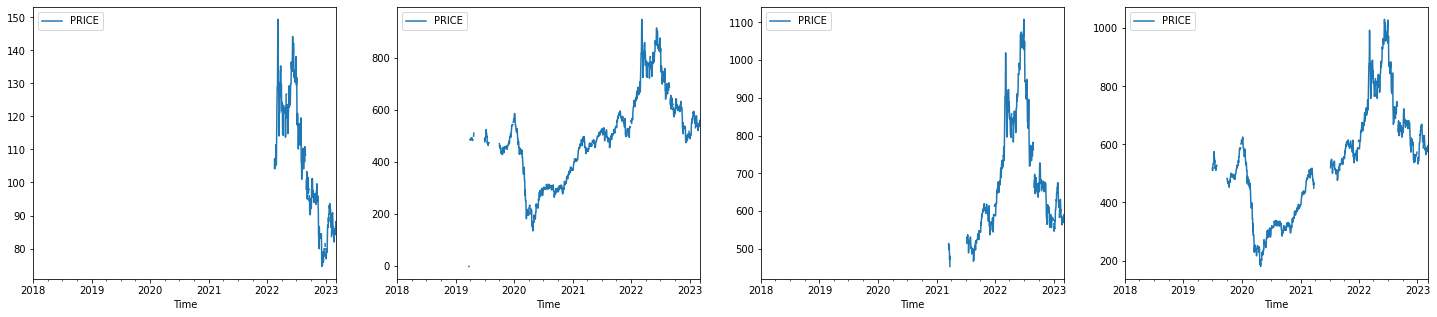

In [36]:
test_price(fuel_models)

have to convert back to usd/bbl from usd/tn curves due to lack of available data

In [24]:
prices = {
'brent_m1':'model://PI_OIL_CRU_ICE/PI.BRENT.ICESWAP.USD.BBL.C/CURVE/M01/FINAL',
'brent_m2':'model://PI_OIL_CRU_ICE/PI.BRENT.ICESWAP.USD.BBL.C/CURVE/M02/FINAL',
'doba':"model://PLATTS_RI/PLATTS.CRUDE.RI.AAXUV00",
'dtd':"model://PLATTS_RI/PLATTS.CRUDE.RI.PCAAS00",
# 'structure':"model://PLATTS_RI/PLATTS.CRUDE.RI.BVBM012",
# 'lsfo':'model://PI_OIL_PROD_HEA/PI.FO10.CCIFNWE.USD.MT.C/CURVE/M00/FINAL',
'vlsfo_rotts_bbl':'model://PI_OIL_PROD_HEA/PI.MARINEFO.BFOBRDAM.USD.BBL.C/CURVE/M02/FINAL',
'vlsfo_rotts_mt':'model://PI_OIL_PROD_HEA/PI.MARINEFO.BFOBRDAM.USD.MT.C/CURVE/M02/FINAL',
'nap_rotts_brgs':'model://PI_OIL_PROD_LIG/PI.NAPHTHA.BFOBRDAM.USD.MT.C/CURVE/M02/FINAL',
# 'nap_nwe_bbl':'model://PI_OIL_PROD_LIG/PI.NAPHTHA.CCIFNWE.USD.BBL.C/CURVE/M00/FINAL',
# 'nap_nwe_mt':'model://PI_OIL_PROD_LIG/PI.NAPHTHA.CCIFNWE.USD.MT.C/CURVE/M00/FINAL',     
'freight_rotts' : 'model://PLATTS_TD/PLATTS.FR.TD.TDACR00',
'freight_meg':"model://PLATTS_TD/PLATTS.FR.TD.TDWAI00",
'freight_asia':"model://PLATTS_TD/PLATTS.FR.TD.TDACM00",
# 'vlsfo_sing':"model://PLATTS_CX/PLATTS.OIL.CX.AMFSB00/", 
'vlsfo_sing':"model://PI_OIL_PROD_HEA/PI.MARINEFO.CFOBSING.USD.MT.C/CURVE/M02/FINAL",
"vlsfo_fuj":"model://PI_OIL_PROD_HEA/PI.MARINEFO.CFOBFUJA.USD.MT.C/CURVE/M02/FINAL",
"ag_nap":"model://PI_OIL_PROD_LIG/PI.NAPHTHA.ARABGULF.USD.MT.C/CURVE/M02/FINAL",
'nap_sing':"model://PLATTS_CS/PLATTS.OIL.CS.PAAAP00",
'w3':"model://PVM_MTM/EU.OIL.CFD_LC.NSEA.PVM.FWD.W04/CLOSE/ALL",
'w4':"model://PVM_MTM/EU.OIL.CFD_LC.NSEA.PVM.FWD.W05/CLOSE/ALL",
'w5':"model://PVM_MTM/EU.OIL.CFD_LC.NSEA.PVM.FWD.W06/CLOSE/ALL",
'w6':"model://PVM_MTM/EU.OIL.CFD_LC.NSEA.PVM.FWD.W07/CLOSE/ALL",
}
raw_table = get_prices_df(model_dict=prices, start=datetime.date(2020,1,1))

In [25]:
def calc_func(df):
    """
    Function to convert prices to bbls and extract a delivered rotterdam number
    """
    x = df.copy()
    x['vlso_rotts_bbl'] = x['vlsfo_rotts_mt']/6.36
    x['vlsfo_fuj'] = x['vlsfo_fuj']/6.36
    x['vlsfo_sing'] = x['vlsfo_sing']/6.36
    x['nap_rotts_brgs'] = x['nap_rotts_brgs']/8.9
    x['ag_nap'] = x['ag_nap']/8.9
    x['freight_rotts'] = x['freight_rotts']* 0.133
    x['freight_meg'] = x['freight_meg']* 0.133
    x['freight_asia'] = x['freight_asia']* 0.133
    x['structure'] = x['brent_m1'] - x['brent_m2']
    x['cfd_structure'] = (x['w3'] - x['w5'])/100
    x['doba_rotts_des'] = x['dtd'] + x['doba'] + x['cfd_structure'] + x['freight_rotts']
    x['doba_meg_des'] = x['dtd'] + x['doba'] + x['structure'] + x['freight_meg']
    # x['doba_asia_des'] = x['dtd'] + x['doba'] + x['structure'] + x['freight_asia']
    x['doba_asia_des'] = x['dtd'] + x['structure'] + x['freight_asia']
    return x

# def convert_bbls():

# def landed_diffs():


In [26]:
def gpw_margins(x):
    x['gpw_rotts'] = (0.85*x['vlso_rotts_bbl'])+(0.1*x['nap_rotts_brgs'])
    x['gpw_asia'] = (0.85*x['vlsfo_sing'])+(0.1*x['nap_sing'])
    x['gpw_meg'] = (0.85*x['vlsfo_fuj'])+(0.1*x['ag_nap'])
    return x

In [27]:
def get_prices_bbls(df):
    df_new = gpw_margins(calc_func(df))
    return df_new[['gpw_rotts','gpw_asia','gpw_meg','doba_rotts_des','doba_meg_des','doba_asia_des']].copy()

In [28]:
def get_splitter_netbacks():
    df = get_prices_bbls(raw_table)
    df['rotts_margin'] = df['gpw_rotts'] - df['doba_rotts_des']
    df['asia_margin'] = df['gpw_asia'] - df['doba_meg_des']
    df['meg_margin'] = df['gpw_meg'] - df['doba_meg_des']
    return df[['rotts_margin','asia_margin','meg_margin']]

In [29]:
# prices_table = get_prices_bbls(raw_table)

In [30]:
netbacks = get_splitter_netbacks().resample('D').interpolate()
traded_doba_diff = get_traded_diffs_cleaned()
# netback_regression = netbacks.merge(traded_doba_diff, left_index=True, right_index=True).drop(columns='meg_margin').dropna()
netback_regression = netbacks.merge(traded_doba_diff, left_index=True, right_index=True).dropna()

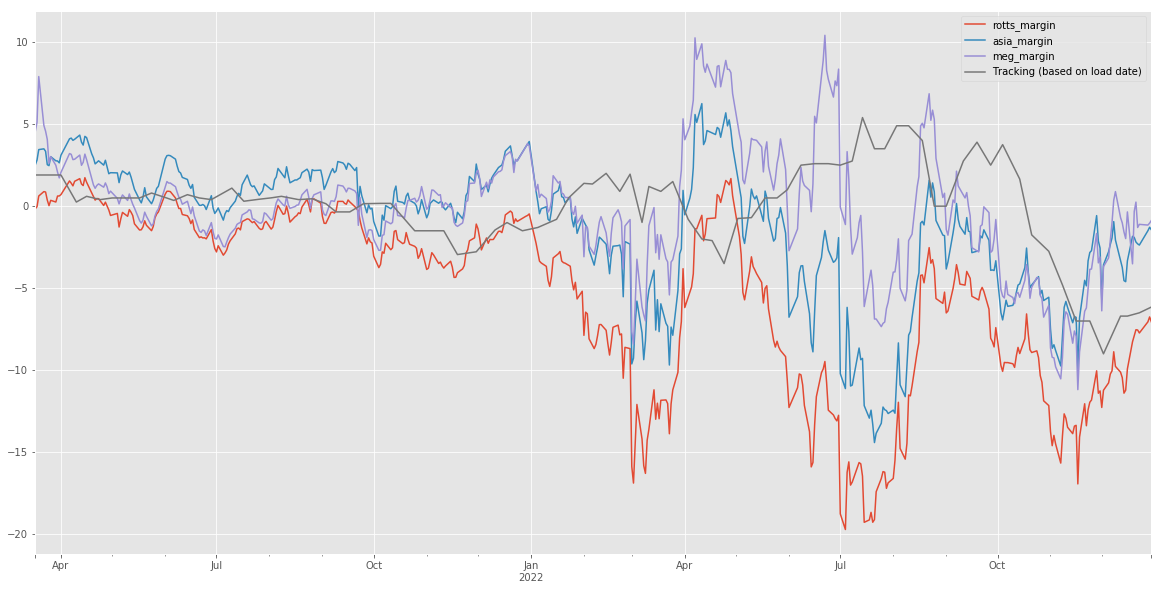

In [31]:
netback_regression.plot(figsize=(20,10))

In [92]:
# # modeling OLS 
x = netback_regression[['rotts_margin', 'asia_margin']]
y = netback_regression['Tracking (based on load date)']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     Tracking (based on load date)   R-squared:                       0.177
Model:                                       OLS   Adj. R-squared:                  0.176
Method:                            Least Squares   F-statistic:                     117.3
Date:                           Fri, 10 Mar 2023   Prob (F-statistic):           7.00e-47
Time:                                   14:34:47   Log-Likelihood:                -2392.6
No. Observations:                           1094   AIC:                             4791.
Df Residuals:                               1091   BIC:                             4806.
Df Model:                                      2                                         
Covariance Type:                       nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.9269      0.171     11.273      0.000       1.591       2.262
rotts_margin     0.4830      0.041     11.761      0.000       0.402       0.564
asia_margin     -0.6578      0.048    -13.688      0.000      -0.752      -0.563
==============================================================================
Omnibus:                      130.486   Durbin-Watson:                   0.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              225.411
Skew:                          -0.780   Prob(JB):                     1.13e-49
Kurtosis:                       4.585   Cond. No.                         25.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [93]:
var_regression = netback_regression.diff().drop(columns='rotts_margin')

Granger causality F-test. H_0: Tracking (based on load date) does not Granger-cause asia_margin. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         6.028          3.872   0.015 (1, 306)
---------------------------------------------- Granger causality F-test. H_0: asia_margin does not Granger-cause Tracking (based on load date). Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         9.865          3.872   0.002 (1, 306)
----------------------------------------------


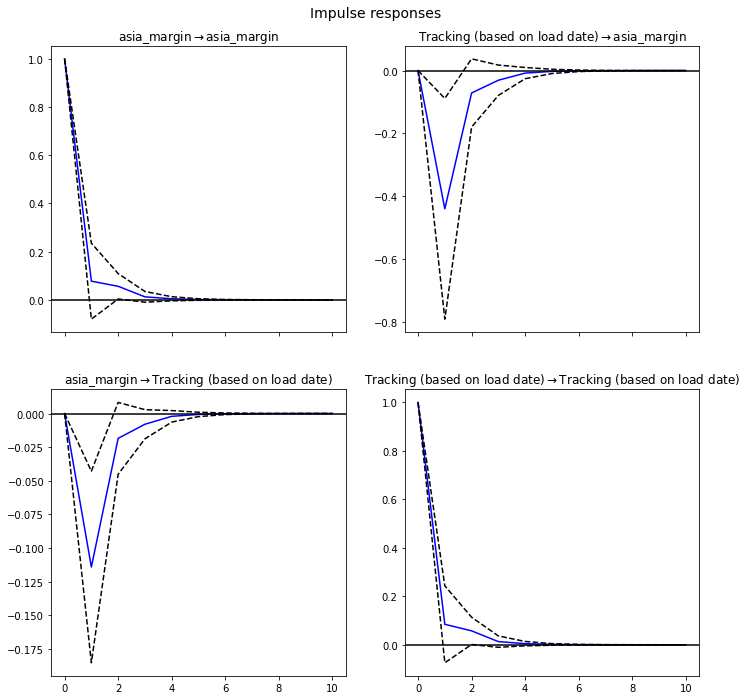

In [94]:
model = sm.tsa.VAR(endog=var_regression.resample('W').mean().dropna()).fit()
model.irf().plot()
print(model.test_causality('asia_margin', ['Tracking (based on load date)'], kind='f').summary(), model.test_causality('Tracking (based on load date)', ['asia_margin'], kind='f').summary())

In [74]:
# ax = netbacks.plot(figsize=(20,10))
# ax2 = ax.twinx()
# traded_doba_diff.plot(figsize=(20,10), ax=ax2)

### calculating splitter netbacks as regressors

In [116]:
vlsfo = 'model://PLATTS_CX/PLATTS.OIL.CX.AMFSB00'
naphtha = 'model://PLATTS_CS/PLATTS.OIL.CS.PAABP00'
vl = dg.get_time_series(vlsfo, from_date = datetime.date(2020,1,1), to_date=datetime.date.today()).resample('D').ffill()
nap = dg.get_time_series(vlsfo, from_date = datetime.date(2020,1,1), to_date=datetime.date.today()).resample('D').ffill()
df = pd.concat([vl,nap], axis=1)
df.columns = ['vlsfo', 'naphtha']
df.to_csv('prods.csv')

In [112]:
len(vl)

1115

In [113]:
len(nap)

1115

In [114]:
df = pd.concat([vl, nap])

In [115]:
df

PRICE
Time               
2020-01-01      NaN
2020-01-02   98.780
2020-01-03  102.003
2020-01-04  102.003
2020-01-05  102.003
...             ...
2023-01-15   93.603
2023-01-16   94.587
2023-01-17   96.942
2023-01-18   99.167
2023-01-19   97.548

[2230 rows x 1 columns]